In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn import metrics
import seaborn as sn

<font color=red size=5cm>INPUT DATA</font>

In [ ]:
def inputTraining():
    trainingDataFrame = pd.read_csv("./trainingandtestdata/training.1600000.processed.noemoticon.csv",encoding = "latin-1", header=None, usecols=[0,5],names=['A','B'],index_col=False)
    return trainingDataFrame
    

def inputTesting():
    df = pd.read_csv("./trainingandtestdata/testdata.manual.2009.06.14.csv",encoding = "latin-1", header=None, usecols=[0,5],names=['A','B'],index_col=False)
    data = df.to_numpy()
    data = data[np.where(data[:,0]!=2)]
    testingDataFrame = pd.DataFrame({'A': data[:, 0], 'B': data[:, 1]})
    return testingDataFrame

In [ ]:
trainingDataFrame = inputTraining()
testingDataFrame = inputTesting()

<font color =red size=5cm>DATA DESCRIPTION</font>

In [ ]:
# A = Polarity
# B = TweetID
# C = date of the tweet 
# D = query (lyx)
# E = user
# F = tweet

#-----------CLASS------------

#class 0 Negative 
#calss 4 Positive

<font color = red size=5cm>CREATING VOCABULARY</font>

In [ ]:
# creating vocabulary of all words in training data

def vocabulary(data):
    """
    Inputs data in numpy format
    Col 0: Label
    Col 1: Text
    """
    data_class0 = data[np.where(data[:,0]==0)]
#     data_class2 = data[np.where(data[:,0]==2)]
    data_class4 = data[np.where(data[:,0]==4)]
    dataClassList  = [data_class0,data_class4]
    
    vocab_class0 = dict()
    vocab_class4 = dict()
    
    TotalVocab = dict()
    wc = []
    vocabClassList = [vocab_class0,vocab_class4]
    for i,j in zip(dataClassList,vocabClassList):
        totalWordCountInClass = 0
        tweetList = i[:,1]
        for tweet in tweetList:
            tweetlist = tweet.replace(","," ").replace("."," ").split()
#             tweetlist = tweet.split()
            for words in tweetlist:
                totalWordCountInClass+=1
                if words in j:
                    j[words]+=1
                    TotalVocab[words]+=1
                elif words in TotalVocab:
                    TotalVocab[words]+=1
                    j[words]=1
                else:
                    TotalVocab[words] = 1
                    j[words] = 1
                    
               
                    
        wc.append(totalWordCountInClass)
    print("Vocalbulary done")
    return vocab_class0,vocab_class4, TotalVocab,wc

<font color = red size=5cm>CALCULATING PARAMETERS</font>

In [6]:
# finding parameters

def FindPhi(data):
    """
    Inputs data in numpy format
    Col 0: Label
    Col 1: Text
    """
    phi = np.zeros((2,1))
    phi[0,0] = (np.count_nonzero(data[:,0] == 0)+1)/(data.shape[0]+2)
    phi[1,0] = (np.count_nonzero(data[:,0] == 4)+1)/(data.shape[0]+2)
    return phi

def Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc):
    #----------------------------------------------------------------------------------------
    theta = dict()
    #--------------------------------------------------------------------------------------------
   
    for words in TotalVocab:
        theta[words] = []

        theta_ofThe_Word = 0
        if words in vocab_class0:
            theta_ofThe_Word = (vocab_class0[words] + 1)/(wc[0] + len(TotalVocab))
        else:
            theta_ofThe_Word = 1/(wc[0] + len(TotalVocab))
        theta[words].append(theta_ofThe_Word)
            
    #---------------------------------------------------------------------------------------------

        theta_ofThe_Word = 0
        if words in vocab_class4:
            theta_ofThe_Word = (vocab_class4[words] + 1)/(wc[1]+ len(TotalVocab))
        else:
            theta_ofThe_Word = 1/(wc[1]+ len(TotalVocab))
        theta[words].append(theta_ofThe_Word)
        
    #----------------------------------------------------------------------------------------------
    print("parameters calculated")
    return theta

<font color =red size=5cm>PREDICTING :</font>
<font color = blue size=4cm>Accuracy, Confusion Matrix and Probablity </font>

In [7]:
def Predicting(TestingData,theta,phi):

    prediction = []
    postiveProbality = []
    for tweet in TestingData[:,1]:
        class0 = phi[0,0]
        class4 = phi[1,0]
        
        tweetlist = tweet.replace(","," ").replace("."," ").split()
        
        #CALCULATE PROBABILTY
        for words in tweetlist:
            if words in theta:
                class0 += math.log(theta[words][0]) 
            else:
                class0 += math.log(1/(len(tweetlist) + len(theta)))
            
            if words in theta:
                class4 += math.log(theta[words][1]) 
            else :
                class4 += math.log(1/(len(tweetlist) + len(theta)))
        
        class0 += math.log(phi[0,0])
        class4 += math.log(phi[1,0])
        postiveProbality.append(class4)
        if class0 > class4:
            prediction.append(0)
        else:
            prediction.append(4)
            
    count =0
    correct_class0 = 0
    correct_class4 = 0
    incorrect_class0 = 0
    incorrect_class4 = 0
    for i in  range(TestingData.shape[0]):
        if prediction[i] == TestingData[i,0]:
            if prediction[i] == 0:
                correct_class0+=1
            else:
                correct_class4+=1
            count+=1
        else:
            if prediction[i]==0:
                incorrect_class4+=1
            else:
                incorrect_class0+=1
    
    confusionMatrix = np.array([[correct_class0,incorrect_class4],[incorrect_class0,correct_class4]])
    Accurarcy = (count/TestingData.shape[0])*100
        
    return Accurarcy,confusionMatrix,postiveProbality

# PART 1-A

In [8]:
def part1A(trainingDataFrame,testingDataFrame):
    
    #-------------------LEARNING-------------------------------------------------------
    trainDataframe = trainingDataFrame.copy()
    trainDataframe["B"] =  trainDataframe["B"].str.replace(","," ").str.replace("."," ")
    TrainingData = trainDataframe.to_numpy()
    (vocab_class0,vocab_class4, TotalVocab,wc) = vocabulary(TrainingData)
    phi = FindPhi(TrainingData)
    theta  = Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc)
    #----------------------------------------------------------------------------------
    
    #------------------TESTING---------------------------------------------------------
    testDataFrame = testingDataFrame.copy()
    testDataFrame["B"] =  testDataFrame["B"].str.replace(","," ").str.replace("."," ")
    TestingData = testDataFrame.to_numpy()
    Accurarcy, confusionMatrixTEST_1A, postiveProbalityTEST_1A = Predicting(TestingData,theta,phi)
    print("Accurarcy over TESTING data is :",Accurarcy," %")
    #----------------------------------------------------------------------------------
    
    #------------------TRAINING--------------------------------------------------------
    Accurarcy, confusionMatrixTRAIN_1A, postiveProbalityTRAIN_1A = Predicting(TrainingData,theta,phi)
    print("Accurarcy over TRAINING data is :",Accurarcy," %")
    #-----------------------------------------------------------------------------------
    return confusionMatrixTEST_1A, postiveProbalityTEST_1A, postiveProbalityTRAIN_1A

In [9]:
confusionMatrixTEST_1A, postiveProbalityTEST_1A, postiveProbalityTRAIN_1A = part1A(trainingDataFrame,testingDataFrame)

Vocalbulary done
parameters calculated
Accurarcy over TESTING data is : 80.77994428969359  %
Accurarcy over TRAINING data is : 84.932875  %


# PART 1-B

<font color=red size=5cm>RANDOM PREDICTION</font>

In [10]:
def randomPrediction(size):
    """
    Give a size,
    returns random choices 
    given a target to choose from.
    """
    import random
    targets =[0,4]
    randomPrediction =[]
    for i in range(size):
        randomPrediction.append(random.choice(targets))
    return randomPrediction

In [11]:
def part1B(testingDataFrame):
    TestingData  = testingDataFrame.to_numpy()
    randomPredict =randomPrediction(TestingData.shape[0])
    match = 0
    for i in range(TestingData.shape[0]):
        if randomPredict[i] == TestingData[i,0]:
            match +=1
    randomAcc = (match*100)/TestingData.shape[0]
    print("Random guessing accuracy on test data is ",randomAcc," %")

In [13]:
part1B(testingDataFrame)

Random guessing accuracy on test data is  51.532033426183844  %


# PART 1-C

In [14]:
def ConfusionMatrix(confusionMatrixTEST_1A):
    df_cm = pd.DataFrame(confusionMatrixTEST_1A ,index = [i for i in [0,4]],
                      columns = [i for i in [0,4]], dtype=int)
    plt.figure(figsize = (6,4))
    sn.heatmap(df_cm, annot=True,fmt='d')
    plt.xlabel("ACTUAL VALUE",fontsize = 15)
    plt.ylabel("PREDICTED VALUE",fontsize = 15)
    plt.title("Confusion Matrix: TEST",color ="red",size=20)
    plt.show()

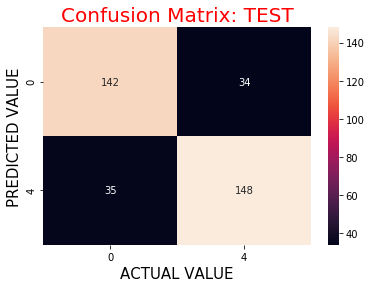

In [15]:
ConfusionMatrix(confusionMatrixTEST_1A)

# PART 1-D

<font color=red size=5cm>TOKENIZATION, STOPPING ADND STEMMING</font>

In [16]:
def cleaningData(df):
    """
    Takes dataframes as input 
    and returns a cleaned dataframe.
    """
    #----------Cleaning URLs ------------------------------------
    def removeURL(text):
        return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    
    df["B"] = df["B"].apply(lambda text: removeURL(text) )
    #------------------------------------------------------------
    
    
    #-------------Cleaning punctuation---------------------------
    def removePunctuation(text):    
#         punctuation =  '!"#$\()*+/<=>?[\\]^_`{|}~'
        punctuation =  '!"#{}'
        for c in punctuation:
            text= text.replace(c,"")
        return text
    
    df["B"] = df["B"].apply(lambda text: removePunctuation(text) )
    #-------------------------------------------------------------
    
    
    #-------------Tokenization------------------------------------
    def tokenization(text):
#         pointOfSplit = ',.:;'
        pointOfSplit = ',.'
        for c in pointOfSplit:
            text= text.replace(c," ")
        return text.lower().split()
    
    df["B"] = df["B"].apply(lambda text: tokenization(text) )
    #--------------------------------------------------------------
    
    
    #-----------english stoppers and stemmer---------------------
    stops = set(stopwords.words("english"))
    stemmer = SnowballStemmer("english")
    
    df['B'] = df['B'].apply(lambda x: [stemmer.stem(item) for item in x if item not in stops and not item.startswith('@')])
    
    df['B'] =  df['B'].apply(lambda x: " ".join(x))
    #------------------------------------------------------------

    return df 

In [17]:
def part1D(trainingDataFrame,testingDataFrame):
    s =time.time()
    
    trainDataframe = trainingDataFrame.copy()
#     
#     trainDataframe =  cleaningData(trainDataframe)  # CLEANING THE TRAINING DATA
#     with open('cleanTrainData','wb') as f:
#         pickle.dump(trainDataframe, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open('cleanTrainData','rb') as f:
        trainDataframe = pickle.load(f)
    TrainingData = trainDataframe.to_numpy()
    
    
    #-------------------LEARNING-------------------------------------------------------
    (vocab_class0, vocab_class4, TotalVocab,wc) = vocabulary(TrainingData)
    phi = FindPhi(TrainingData)
    theta  = Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc)
    #----------------------------------------------------------------------------------
    
    
    #------------------TESTING---------------------------------------------------------
    testDataFrame = testingDataFrame.copy()
    testDataFrame =  cleaningData(testDataFrame) # CLEANING THE TESTING DATA
    TestingData = testDataFrame.to_numpy()
    Accurarcy, confusionMatrixTEST_1D, postiveProbalityTEST_1D = Predicting(TestingData,theta,phi)
    print("Accurarcy over TESTING data is :",Accurarcy," %\n")
    #----------------------------------------------------------------------------------
    

    print("TOTAL TIME :",time.time()-s)
    return postiveProbalityTEST_1D

In [18]:
postiveProbalityTEST_1D = part1D(trainingDataFrame,testingDataFrame)

Vocalbulary done
parameters calculated
Accurarcy over TESTING data is : 82.17270194986072  %

TOTAL TIME : 8.547100067138672


# PART 1-E

<font color =red size = 5cm> FEATURE ENGINEERING </font>

In [19]:
def bigramification(Data):
    """
    Takes data as numpy ndarray
    """
    data = Data.copy()
    for index in range(data.shape[0]):
        newData = []
        rowList = data[index,1].split()
        for i in range(len(rowList)-1):
            newData.append(rowList[i])
            newData.append(rowList[i]+rowList[i+1])
        data[index,1] = " ".join(newData.copy())
    return data


In [20]:
def POS_tagging():
    from nltk.tokenize import word_tokenize, sent_tokenize 

    with open('cleanTrainData','rb') as f:
        trainDataframe = pickle.load(f)

    trainDataframe["B"] = trainDataframe["B"].str.split()
    trainDataframe["B"]=trainDataframe["B"].apply(lambda wordsList:nltk.pos_tag(wordsList))
    with open('POS_TaggedTrain','wb') as f:
        pickle.dump(trainDataframe,f)

In [21]:
def POS_Data():
    with open('cleanTrainData','rb') as f:
        trainDataframe = pickle.load(f)
        
    with open('POS_TaggedTrain','rb') as f:
        tagged_trainDataframe = pickle.load(f)
        
    trainData = trainDataframe.to_numpy()
#     POS_tagges = ["JJ","JJR","JJS","RB","RBR","RBS","VB","VBD","VBG","VBN","VBP"]
#     POS_tagges = ["RB","RBR","RBS","VB","VBD","VBG","VBN","VBP"]
    POS_tagges = ["RB","RBR","RBS"]
    text = []
    for i in tqdm(range(tagged_trainDataframe.shape[0])):
        tweetWordList = []
        for j in tagged_trainDataframe["B"][i]:
            if j[1] in POS_tagges:
                tweetWordList.append(j[0])
                tweetWordList.append(j[0])
                tweetWordList.append(j[0])
            else:
                tweetWordList.append(j[0])
        trainData[i,1] = " ".join(tweetWordList)
                
    dataset = pd.DataFrame({'A': trainData[:, 0], 'B': trainData[:, 1]})
    return dataset

In [22]:
def featureEngineering():

    
    #-----POS-----------------------------------
    trainDataframe = POS_Data()
    #-------------------------------------------
    
    testingDataFrame = inputTesting()
    
    TrainingData = trainDataframe.to_numpy()
    
    testDataFrame =  cleaningData(testingDataFrame)
    TestingData = testDataFrame.to_numpy()
    
    #------ADDING FEATURES: BIGRAM-----------------
    TrainingDataBG =  bigramification(TrainingData)
    TestingDataBG =  bigramification(TestingData)
    #----------------------------------------------
    
    
    #------------------LEARNING-------------------------------
    (vocab_class0, vocab_class4, TotalVocab,wc) = vocabulary(TrainingDataBG)
    phi = FindPhi(TrainingData)
    theta  = Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc)
    #---------------------------------------------------------
    
    
    #---------------------TESTING---------------------------------------
    Accurarcy, confusionMatrixTEST_1E, postiveProbalityTEST_1E = Predicting(TestingData,theta,phi)
    print("Accurarcy over TESTING data is :",Accurarcy," %")
    
    #------------------------------------------------------------------------
    
    return postiveProbalityTEST_1E
    

In [23]:
postiveProbalityTEST_1E = featureEngineering()

100%|██████████| 1600000/1600000 [00:58<00:00, 27156.60it/s]


Vocalbulary done
parameters calculated
Accurarcy over TESTING data is : 83.56545961002786  %


# PART 1-F

<font color = red size=5cm>TF-IDF</font>

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm

In [25]:
def tfidf(trainingDataFrame,testingDataFrame):
    with open('cleanTrainData','rb') as f:
        trainDataframe = pickle.load(f)
        
    vectorizer = TfidfVectorizer(min_df=0.0007)
#     vectorizer = TfidfVectorizer()
    
    X_tfidf = vectorizer.fit_transform(trainDataframe['B'])
    
    print("--------------Shape of Train vectorized data------------")
    print(X_tfidf.shape)
    print("--------------------------------------------------------\n")
    
    model = GaussianNB()
    for i in tqdm(range(0,trainDataframe.shape[0],1000)):
        model.partial_fit(X_tfidf[i:i+1000].toarray(), trainDataframe['A'][i:i+1000].to_numpy(), np.array([0,4]))
        
    
    testDataFrame = testingDataFrame.copy()
    testDataFrame =  cleaningData(testDataFrame) # CLEANING THE TESTING DATA
    
    X_test_tfidf = vectorizer.transform(testDataFrame['B'])
    
    print("--------------Shape of Test vectorized data------------")
    print(X_test_tfidf.shape)
    print("--------------------------------------------------------\n")
    
    prediction = model.predict(X_test_tfidf.toarray())
    tfidf_Prob = model.predict_log_proba(X_test_tfidf.toarray())[:,1]
    
    match = 0
    for i in range(len(prediction)):
        if prediction[i] == testDataFrame["A"][i]:
            match += 1
    accurarcy = (match*100)/len(prediction)
    print("Accrarcy is ",accurarcy)
    print("--------------------------------------------------------\n")
    return tfidf_Prob
    
    

In [26]:
tfidf_Prob = tfidf(trainingDataFrame,testingDataFrame)

  0%|          | 6/1600 [00:00<00:30, 52.56it/s]

--------------Shape of Train vectorized data------------
(1600000, 1341)
--------------------------------------------------------



100%|██████████| 1600/1600 [00:25<00:00, 63.45it/s]


--------------Shape of Test vectorized data------------
(359, 1341)
--------------------------------------------------------

Accrarcy is  81.05849582172702
--------------------------------------------------------



<font color = red size=5cm>SKLearn SelectPercentile </font>

In [27]:
def selectPercentile(trainingDataFrame,testingDataFrame):
    
    with open('cleanTrainData','rb') as f:
        trainDataframe = pickle.load(f)
        
    vectorizer = TfidfVectorizer(min_df=0.0007)
    
    X_tfidf = vectorizer.fit_transform(trainDataframe['B'])
    
    selPer = SelectPercentile(f_classif,percentile=20)
    X_tfidf_new = selPer.fit_transform(X_tfidf,trainDataframe['A'].tolist())

    
    print("--------------Shape of Train vectorized data------------")
    print(X_tfidf.shape)
    print(X_tfidf_new.shape)
    print("--------------------------------------------------------\n")
    
    model = GaussianNB()
    for i in tqdm(range(0,trainDataframe.shape[0],1000)):
        model.partial_fit(X_tfidf_new[i:i+1000].toarray(), trainDataframe['A'][i:i+1000].to_numpy(), np.array([0,4]))
        
        
    testDataFrame = testingDataFrame.copy()
    testDataFrame =  cleaningData(testDataFrame) # CLEANING THE TESTING DATA
    
    X_test_tfidf = vectorizer.transform(testDataFrame['B'])
    
    X_test_tfidf_new = selPer.transform(X_test_tfidf)
    
    print("--------------Shape of Test vectorized data------------")
    print(X_test_tfidf.shape)
    print(X_test_tfidf_new.shape)
    print("--------------------------------------------------------\n")
    
    prediction = model.predict(X_test_tfidf_new.toarray())
    selPer_Prob = model.predict_log_proba(X_test_tfidf_new.toarray())[:,1]
    
    match = 0
    for i in range(len(prediction)):
        if prediction[i] == testDataFrame["A"][i]:
            match += 1
    accurarcy = (match*100)/len(prediction)
    print("Accrarcy is ",accurarcy)
    return selPer_Prob

In [28]:
selPer_Prob = selectPercentile(trainingDataFrame,testingDataFrame)

  1%|▏         | 23/1600 [00:00<00:06, 229.91it/s]

--------------Shape of Train vectorized data------------
(1600000, 1341)
(1600000, 268)
--------------------------------------------------------



100%|██████████| 1600/1600 [00:06<00:00, 257.90it/s]


--------------Shape of Test vectorized data------------
(359, 1341)
(359, 268)
--------------------------------------------------------

Accrarcy is  76.32311977715878


# PART 1-G

<font color = red size = 5cm> ROC : RECEIVER OPERATING CHARACTERSTIC </font>

In [29]:
def ROC(y,prob_scores,label,title):
    (fpr, tpr, thresholds) = metrics.roc_curve(y, prob_scores, pos_label=label)
    auc = metrics.roc_auc_score(y, prob_scores)
    p, = plt.plot(fpr,tpr,label="area under curve is "+str(auc),color ='green')
    plt.xlabel("False Positive Rate",color='red')
    plt.ylabel("True Positive Rate",color='red')
    plt.title(title,color ='blue',fontsize = 15)
    plt.legend()
    plt.show()
    return p

In [ ]:
%matplotlib qt


In [ ]:
p1 = ROC(testingDataFrame['A'].tolist(),postiveProbalityTEST_1A,4,"PART A: UNCLEAND DATA")

In [ ]:
p2 = ROC(testingDataFrame['A'].tolist(),postiveProbalityTEST_1D,4,"PART D: CLEANED DATA")

In [ ]:
p3 = ROC(testingDataFrame['A'].tolist(),postiveProbalityTEST_1E,4,"PART E: Feature Engineering")

In [ ]:
p4 = ROC(testingDataFrame['A'].tolist(),tfidf_Prob,4,"PART F: TF-IDF")

In [ ]:
p5 = ROC(testingDataFrame['A'].tolist(),selPer_Prob,4,"PART F: SELECT-PERCENTILE")